# Modeling Weather Geographies using Scikit-Learn

In this notebook, we are using aggregated `TMAX` data by global weather stations in order to create a machine learning model to predict the daily maximum temperatures at any given latitude and longitude. Our model will take 3 continuous predictors: latitude, longitude, and elevation, and provide an estimated `TMAX` for a given day of the year.

Finally, we will show how to save this model to your DSX Local filesystem to be used for online scoring.

<div class="alert alert-block alert-info"> Note: You will need to install the Basemap and GEOS libraries to dynamically produce output maps. For your convinience, the maps have been pre-rendered in this sample notebook.</div>

## Table of Contents
This notebook contains these main sections:

1. [Import Libraries](#Import_Libraries)
2. [The Data](#The_Data)
3. [The Model](#The_Model)
4. [Data Visualization](#Data_Visualization)
5. [Save Model to DSX Filesystem](#Save_Model_to_DSX_Filesystem)
6. [Predict on New Data](#Predict_on_New_Data)
7. [Summary](#Summary)

<a id='Import_Libraries'></a>
## Import Libraries
Run the cell below once to install the `tqdm` library

In [1]:
!pip install --user tqdm

    100% |████████████████████████████████| 61kB 316kB/s ta 0:00:01


Now restart the kernel to ensure that the `tqdm` library is loaded. You can also comment out the above cell in order to avoid reinstalling the library on each runthrough.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
#from mpl_toolkits.basemap import Basemap, maskoceans

import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

<a id='The_Data'></a>
## The Data
The dataset was created using data from the Global Historical Climatology Network. We have averaged the `TMAX` over the entire history of each weather station for the spring and autumn equinox, and the summer and winter solstice.

In [2]:
df_data_1 = pd.read_csv("https://raw.githubusercontent.com/IBMDataScience/DSX-DemoCenter/master/weatherGeographies/data_assets/seasonal_data.csv")

Let's pull out the data from Boston's Logan International Airport:

In [3]:
df_data_1[df_data_1['name'].str.contains('BOSTON LOGAN')]

,id,latitude,longitude,elevation,country,name,state,21-Mar,21-Jun,21-Sep,21-Dec
27094,USW00014739,42.3606,-71.0106,3.7,US,BOSTON LOGAN INTL AP,MA,7.690244,25.507407,21.975309,3.892593


As shown above, we have the lat-lon coordinates, and elevation data for the station. The last four columns determine the average daily maximum temperatures over the history of the station in Celsius. For example, the average `TMAX` on the 21st of June over all the recorded history for Logan Airport's weather station is 25.5$^{\circ}$C.

<a id='The_Model'></a>
## The Model
Let's first split the data by columns into features and response variables, and then further into training and testing sets.

In [4]:
x = df_data_1[['elevation','latitude','longitude']]
y = df_data_1[['21-Mar','21-Jun','21-Sep','21-Dec']]

x_init, x_test, y_init, y_test = train_test_split(x, y['21-Jun'], test_size=.25)

We will fit a **Gradient Boosting Regressor** model. We should first tune our model for the hyperparameter `n_estimators` to discover what is the maximum number of estimators we should use.

In [5]:
x_train, x_val, y_train, y_val = train_test_split(x_init, y_init, test_size=.25)

Now we can iterate over a specified range to determine the best value for `n_estimators`

In [6]:
n_est = list(range(1,201))
val_mad = list()
for n in tqdm(n_est):
    val_model = GradientBoostingRegressor(n_estimators=n)
    val_model.fit(x_train,y_train)
    val_pred = val_model.predict(x_val)
    val_mad.append(mean_absolute_error(y_val,val_pred))

100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Let's plot our estimators vs. error plot to see what a good cutoff for n_estimators should be.

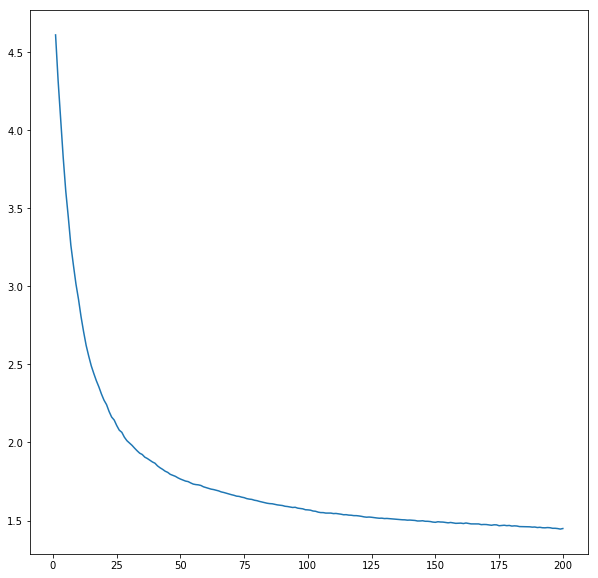

In [7]:
plt.rcParams['figure.figsize'] = (10,10)
plt.plot(n_est,val_mad)
plt.show()

### Finding the Elbow
In order to find the optimal value of `n_estimators`, we'll calculate the equation of the line between our minimum and maximum value of `n_estimators`, and find out the value of `n` in which the validation error is the furthest away from the line.

The best value of n is 33


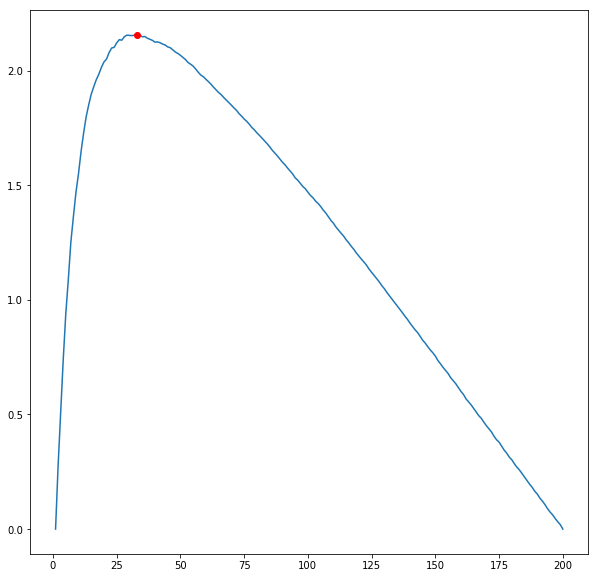

In [8]:
slope = (val_mad[-1]-val_mad[0])/(n_est[-1]-n_est[0])
intercept = val_mad[0] - slope*n_est[0]
val_diff = np.array(n_est)*slope+intercept-np.array(val_mad)
plt.plot(n_est,val_diff)

best_n = (np.array(n_est)*slope+intercept-np.array(val_mad)).argmax()
plt.plot(n_est[best_n],val_diff[best_n], 'ro')
print("The best value of n is {}".format(n_est[best_n]))
plt.show()

Using the best number of estimators from above, we'll fit the model we'll use for prediction on the test set.

In [9]:
gbtr = GradientBoostingRegressor(n_estimators=n_est[best_n])
gbtr.fit(x_train,y_train)
y_pred = gbtr.predict(x_test)
print("Mean Absolute Error: {}\nR^2 value: {}".format(mean_absolute_error(y_pred,y_test),gbtr.score(x_test,y_test)))

Mean Absolute Error: 1.98250334055
R^2 value: 0.795319447765


Not bad! Remember that we are dealing with degrees Celsius. Our mean error in this case around 2 degrees. We also have a strong $R^2$ value.

Now let's fit the models on the entirety of the data, and then produce a grid of predicted `TMAX` values to visualize on a map.

In [10]:
gbtr.fit(x,y['21-Jun'])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=33, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

And now the model for the December 21

In [11]:
gbtr_dec = GradientBoostingRegressor(n_estimators=n_est[best_n])
gbtr_dec.fit(x,y['21-Dec'])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=33, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

<a id='Data_Visualization'></a>
## Data Visualization
Let's pull a matrix of elevation data. The data will contain elevations at latitudes [-90,90], every degree and longitudes [-180,180), every 2 degrees. We'll provide the latitude, longitude, and elevation from this matrix to create a matrix of the same size that contains predicted temperature information.

In [12]:
z = pd.DataFrame(np.empty([181,180]))
elevations = pd.read_csv("https://raw.githubusercontent.com/IBMDataScience/DSX-DemoCenter/master/weatherGeographies/data_assets/elevation.csv", index_col=0)

# Make sure that the matrices are indexed by (lon,lat) values
elevations.columns = elevations.columns.astype(int)
z.columns = elevations.columns
z.index = elevations.index

### Plots
We'll use `matplotlib` Basemap to plot our data. First, we should fill our empty `z` temperature matrix with the predicted temperatures. Then we must flip the matrix, as Basemap wants 90$^{\circ}$S to be the first row in the matrix.

<div class="alert alert-block alert-info"> If you have installed the Basemap and GEOS libraries, copy the code below in a python cell to dynamically produce an output map</div>

```python
for lon in range(-180,180,2):
    for lat in reversed(range(-90,91,1)):
        z[lon][lat] = gbtr.predict(pd.DataFrame({
            0: [lat],
            1: [lon],
            2: [elevations[lon][lat]]
        }))

plt.rcParams['figure.figsize'] = (15,15)
m = Basemap()
lon, lat = np.meshgrid(list(range(-180,180,2)),list(range(-90,91,1)))
x1,y1 = m(lon,lat)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.drawmapboundary()
z1 = maskoceans(x1,y1,np.flip(np.array(z),axis=0))
cs = m.contourf(x1,y1,z1, 15)
plt.show()
```
![](https://github.com/IBMDataScience/DSX-DemoCenter/raw/master/weatherGeographies/notebooks/static/jun21.png)

This is a fairly predictable distribution of temperatures for the 21st of June. Africa and the southern United States are scortching hot, while Antarctica is frigidly cold. Elevation data has also proved to be important, as the himalayas and tibet are marked to be colder than other regions at the same latitude, just as expected. It would be interesting to see how our map would differ if we used 21st of December data:

```python
for lon in range(-180,180,2):
    for lat in reversed(range(-90,91,1)):
        z[lon][lat] = gbtr_dec.predict(pd.DataFrame({
            0: [lat],
            1: [lon],
            2: [elevations[lon][lat]]
        }))

m = Basemap()
lon, lat = np.meshgrid(list(range(-180,180,2)),list(range(-90,91,1)))
x1,y1 = m(lon,lat)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.drawmapboundary()
z1 = maskoceans(x1,y1,np.flip(np.array(z),axis=0))
cs = m.contourf(x1,y1,z1, 15)
plt.show()
```
![](https://github.com/IBMDataScience/DSX-DemoCenter/raw/master/weatherGeographies/notebooks/static/dec21.png)

The model has done an excellent job in estimating the temperatures on 21-Dec. As expected, the southern hemisphere is in summer, and thus hot, while North America and Europe are in Winter. 

<a id='Save_Model_to_DSX_Filesystem'></a>
## Save Model to DSX Filesystem
We can now save `scikit-learn` models to the DSX filesystem for publishing, scoring, deployment, and evaluations. First, import the `save` function from the `dsx_ml.ml` library. The save function takes a few arguments which are listed below.

In [13]:
from dsx_ml.ml import save

Using TensorFlow backend.
/opt/conda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Now we can save both the June 21 and December 21 models.

In [14]:
save(model = gbtr,
     name = 'June21',
     x_test = x,
     y_test = pd.DataFrame(y['21-Jun']),
     algorithm_type = 'Regression')

{'path': '/user-home/999/DSX_Projects/dsx-samples/models/June21/1',
 'scoring_endpoint': 'https://ibm-nginx-svc.ibm-private-cloud.svc.cluster.local/v3/project/score/Python27/scikit-learn-0.19/dsx-samples/June21/1'}

In [15]:
save(model = gbtr_dec,
     name = 'Dec21',
     x_test = x,
     y_test = pd.DataFrame(y['21-Dec']),
     algorithm_type = 'Regression')

{'path': '/user-home/999/DSX_Projects/dsx-samples/models/Dec21/1',
 'scoring_endpoint': 'https://ibm-nginx-svc.ibm-private-cloud.svc.cluster.local/v3/project/score/Python27/scikit-learn-0.19/dsx-samples/Dec21/1'}

### Model Metadata
The model will be stored in the models directory in your DSX Project. Each model is stored as a directory, in which the model artifact and metadata are stored. The metadata is stored as a JSON file, which we can open and display.

In [16]:
import json
import os

proj_dir = os.environ['DSX_PROJECT_DIR']

with open('{}/models/Dec21/metadata.json'.format(proj_dir),'r') as infile:
    metadata_dict = json.load(infile)

print("Runtime: {}".format(metadata_dict['runtime']))
print("Model Type: {}".format(metadata_dict['type']))
print("Algorithm: {}".format(metadata_dict['algorithm']))

print("Feature(s):")
for feature in metadata_dict['features']:
    print('    '+feature['name'])

print("Latest Model Version: {}".format(metadata_dict['latestModelVersion']))
print("Label(s):")
for label in metadata_dict['labelColumns']:
    print('    '+label['name'])

Runtime: Python27
Model Type: scikit-learn-0.19
Algorithm: GradientBoostingRegressor
Feature(s):
    elevation
    latitude
    longitude
Latest Model Version: 1
Label(s):
    21-Dec


<a id='Predict_on_New_Data'></a>
## Predict on New Data

Let's make some predictions using new data. Below we have gathered the latitude, longitude, and elevation data for the cities of Chicago, IL and Miami, FL.

In [17]:
chicago_data = {
    "elevation" : 200.6,
    "latitude" : 41.995,
    "longitude" : -87.9336
}

miami_data = {
    "elevation" : 1,
    "latitude" : 25.7616798,
    "longitude" : -80.1917902
}

We can call the predict function of our models and print them below:

In [18]:
new_data = pd.DataFrame([chicago_data, miami_data])

jun21_temps = gbtr.predict(new_data)
dec21_temps = gbtr_dec.predict(new_data)


output_str = (u'On June 21, it is predicted to be ' +
    str(jun21_temps[0].round(1)) + 
    u'\N{DEGREE SIGN} C in Chicago, and '+ 
    str(jun21_temps[1].round(1)) + 
    u'\N{DEGREE SIGN} C in Miami\n' + 
    u'On December 21, it is predicted to be ' + 
    str(dec21_temps[0].round(1)) + 
    u'\N{DEGREE SIGN} C in Chicago, and ' + 
    str(dec21_temps[1].round(1)) +
    u'\N{DEGREE SIGN} C in Miami')


print(output_str)

On June 21, it is predicted to be 26.9° C in Chicago, and 31.5° C in Miami
On December 21, it is predicted to be 1.5° C in Chicago, and 22.4° C in Miami


<a id='Summary'></a>
## Summary
In this notebook you learned how to create a `scikit-learn` model, create some data visualizations, and save the model in the DSX local environment.

<div class="alert alert-block alert-info">Note: To save resources and get the best performance please use the code below to stop the kernel before exiting your notebook.</div>

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<hr>
Copyright &copy; IBM Corp. 2017. Released as licensed Sample Materials.